# A Deep-Dive on the Effects of Head Coaching Changes in the NBA

## Introduction

The purpose of this project is to investigate the impact of head coach changes on underperforming NBA teams. In the NBA, head coaches are at the forefront of critique when a team underperforms. This usually results in a change of head coaching and, sometimes, the entire coaching staff; but, how effective is this strategy? This project aims to analyze the tangible effects of such coaching transitions on team performance in the subsequent seasons. My focus is on providing a data-driven exploration of the role head coaches play in the NBA and how these changes may influence the team's future performance.

At the end of the 2022-2023 regular season, the Toronto Raptors placed 9th in the Eastern Conference Standings, marking their 2nd missed playoffs in the 3 seasons subsequent to their 2019 Championship run. This led the Raptors parting ways with head coach Nick Nurse as well with the majority of the coaching staff in the summer of 2023. This season, the Raptors hired Darko Rajakovic, an assistant coach from the Memphis Grizzlies to be their new head coach to implement new systems, offensive and defensive philosophies, and to facilitate development of the young Toronto Raptors core.

Coming off high anticipation after the offseason, the Toronto Raptors are 2-4 to start the season. This raises the question: What level of impact can we relaistically expect from these coaching changes? This scenario provides a real-world backdrop for our comprehensive investigation intot he effects of coaching transitions across the NBA.

We seek to answer several questions through exploratory data analysis (EDA):

What is the average number of playoffs clinched within the first 3 years by teams that undergo head coaching changes? How does changing the head coach correlate with the average change in team win percentage in subsequent years? We will also delve into predictive modeling using neural networks (NN). The NN will help us predict the team's future win percentage and determine which seed they could potentially secure in their respective conference. Furthermore, we aim to predict the winningness of the team in subsequent years based on their regular-season records. These predictions will be categorized into:

- High seed team (1-4)
- Low seed team (5-8)
- Out of playoff contention

We can also measure a team's winningness by measuring playoff performance, predicting whether they will:

- Win a championship
- Clinch the conference finals
- Clinch the playoffs

Through this project, we aim to provide data-driven insights into the impact of coaching changes on NBA teams and their future performance, shedding light on the strategies employed in the dynamic world of professional basketball.

## Data Sources

This project uses [Swar's NBA API](https://github.com/swar/nba_api) for the acquisition of data accessible through https://stats.nba.com.

## Collecting the Data

In this section I'll be using the API to collect the data and construct the reporting table.  

In [245]:
# Importing libraries and API endpoints

import pandas as pd
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playoffpicture
from nba_api.stats.endpoints import teamdetails

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import optuna
import matplotlib.pyplot as plt


In [2]:
# Get a list of team info
team_info = teams.get_teams()
head_coaches_data = []

# Iterate through teams and seasons
for team in team_info:
    team_id = team['id']
    team_name = team['abbreviation']
    for season in range(2005, 2024):
        coach_data = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
        coach_data_df = coach_data.coaches.get_data_frame()
        seasons = f"{season}-{str(season+1)[-2:]}"
        if not coach_data_df.empty:
            try:
                coach_name = coach_data_df[coach_data_df['COACH_TYPE'] == 'Head Coach']['COACH_NAME'].values[0]
            except IndexError:
                coach_name = 'None'
        head_coaches_data.append({
            'Team ID': team_id,
            'Season': seasons,
            'Team': team_name,
            'Coach': coach_name
        })

head_coaches_df = pd.DataFrame(head_coaches_data)

In [3]:
# finding no data instances - data isn't really clean 
no_data = head_coaches_df[head_coaches_df['Coach'] == 'None']
no_data

,Team ID,Season,Team,Coach
66,1610612740,2014-15,NOP,None
121,1610612743,2012-13,DEN,None
200,1610612747,2015-16,LAL,None
349,1610612755,2012-13,PHI,None
374,1610612756,2018-19,PHX,None
409,1610612758,2015-16,SAC,None
446,1610612760,2014-15,OKC,None
567,1610612766,2021-22,CHA,None


In [4]:
playoff_picture_df = pd.DataFrame(columns=['Season', 'Seed', 'Team ID', 'Wins', 'Losses', 'Win PCT', 'Clinched Playoffs', 'Clinched Conference'])

for season in range(2005, 2024):
    playoff_picture = playoffpicture.PlayoffPicture(season_id='2' + str(season))

    EastConfStandings_df = playoff_picture.east_conf_standings.get_data_frame()
    EastConfPlayoffPicture_df = playoff_picture.east_conf_playoff_picture.get_data_frame()
    east_team_wins = EastConfStandings_df['WINS']
    east_team_losses = EastConfStandings_df['LOSSES']
    east_team_seed = EastConfPlayoffPicture_df['HIGH_SEED_RANK'].combine_first(EastConfPlayoffPicture_df['LOW_SEED_RANK'])
    east_team_pct = EastConfStandings_df['PCT']
    #east_team = EastConfStandings_df['TEAM']
    east_team_id = EastConfStandings_df['TEAM_ID']
    east_team_clinched_playoffs = EastConfStandings_df['CLINCHED_PLAYOFFS']
    east_team_clinched_conference = EastConfStandings_df['CLINCHED_CONFERENCE']

    east_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': east_team_id,
        'Wins': east_team_wins,
        'Losses': east_team_losses, 
        'Win PCT': east_team_pct,
        'Clinched Playoffs': east_team_clinched_playoffs,
        'Clinched Conference': east_team_clinched_conference
        })
    
    WestConfStandings_df = playoff_picture.west_conf_standings.get_data_frame()
    WestConfPlayoffPicture_df = playoff_picture.west_conf_playoff_picture.get_data_frame()
    west_team_wins = WestConfStandings_df['WINS']
    west_team_losses = WestConfStandings_df['LOSSES']
    west_team_pct = WestConfStandings_df['PCT']
    #west_team = WestConfStandings_df['TEAM']
    west_team_id = WestConfStandings_df['TEAM_ID']
    west_team_clinched_playoffs = WestConfStandings_df['CLINCHED_PLAYOFFS']
    west_team_clinched_conference = WestConfStandings_df['CLINCHED_CONFERENCE']

    west_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': west_team_id,
        'Wins': west_team_wins,
        'Losses': west_team_losses, 
        'Win PCT': west_team_pct,
        'Clinched Playoffs': west_team_clinched_playoffs,
        'Clinched Conference': west_team_clinched_conference
        })
    east_df.reset_index(drop=True, inplace=True)
    west_df.reset_index(drop=True, inplace=True)

    east_df['Seed'] = east_df.index + 1
    west_df['Seed'] = west_df.index + 1

    playoff_picture_df = pd.concat([playoff_picture_df, east_df, west_df])

playoff_picture_df

,Season,Seed,Team ID,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference
0,2005-06,1,1610612765,64,18,0.780,1,1
1,2005-06,2,1610612748,52,30,0.634,1,0
2,2005-06,3,1610612739,50,32,0.610,1,0
3,2005-06,4,1610612751,49,33,0.598,1,0
4,2005-06,5,1610612764,42,40,0.512,1,0
...,...,...,...,...,...,...,...,...
10,2023-24,11,1610612746,4,7,0.364,0,0
11,2023-24,12,1610612762,4,8,0.333,0,0
12,2023-24,13,1610612763,3,9,0.250,0,0
13,2023-24,14,1610612757,3,9,0.250,0,0


In [5]:
data = []
teams = teams.get_teams()
team_id = [team['id'] for team in teams]
all_seasons = [f"{year - 1}-{str(year)[-2:]}" for year in range(2005, 2024)]

for id in team_id:
    champ = teamdetails.TeamDetails(team_id=id)
    champ_df = champ.team_awards_championships.get_data_frame()
    
    if 'YEARAWARDED' in champ_df:
        won_titles = champ_df[champ_df['YEARAWARDED'] >= 2005]
        if not won_titles.empty:
            seasons = won_titles['YEARAWARDED'].apply(lambda year: f"{year - 1}-{str(year)[-2:]}")
            data.extend([(id, season, 1) for season in seasons])

# Fill in missing entries with 0
for id in team_id:
    for season in all_seasons:
        if not any((entry[0] == id and entry[1] == season) for entry in data):
            data.append((id, season, 0))

title_df = pd.DataFrame(data, columns=['Team ID', 'Season', 'Won Title'])
title_df


,Team ID,Season,Won Title
0,1610612738,2007-08,1
1,1610612739,2015-16,1
2,1610612742,2010-11,1
3,1610612743,2022-23,1
4,1610612744,2014-15,1
...,...,...,...
565,1610612766,2018-19,0
566,1610612766,2019-20,0
567,1610612766,2020-21,0
568,1610612766,2021-22,0


In [227]:
combined_df = pd.merge(head_coaches_df, playoff_picture_df, on=['Team ID', 'Season'], how='left')
combined_df = pd.merge(combined_df, title_df, how='left')
combined_df = combined_df.sort_values(by='Season')
combined_df

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0
437,1610612760,2005-06,OKC,Bob Hill,11,35,47,0.427,0,0,0.0
38,1610612739,2005-06,CLE,Mike Brown,3,50,32,0.610,1,0,0.0
418,1610612759,2005-06,SAS,Gregg Popovich,1,63,19,0.768,1,1,0.0
399,1610612758,2005-06,SAC,Rick Adelman,8,44,38,0.537,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
455,1610612760,2023-24,OKC,Mark Daigneault,4,9,4,0.692,0,0,NaN
474,1610612761,2023-24,TOR,Darko Rajakovic,11,5,7,0.417,0,0,NaN
493,1610612762,2023-24,UTA,Will Hardy,12,4,8,0.333,0,0,NaN
531,1610612764,2023-24,WAS,Wes Unseld Jr,14,2,10,0.167,0,0,NaN


## Feature Engineering

**v1 (Current)**
- Coach experience (YoE)
- Coach track record (W/L)
- Historical team performance (T-3 seasons average)

v2
- Player stats

In [250]:
# Creating a seed type for classification

seed_data = []

for seed in combined_df.Seed:
    if seed < 5: 
        seed_data.append(1) # seeds 1-4
    elif seed < 9: 
        seed_data.append(2) # seeds 5-8
    else:
        seed_data.append(3) # below 8th seed

seed_data

[3,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 1,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 1,


In [251]:
#combined_df.drop(columns='Seed Type')
#combined_df.insert(5, 'Seed Type', seed_data)
combined_df

,Team ID,Season,Team,Coach,Seed,Seed Type,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,New Coach
0,1610612737,2005-06,ATL,Mike Woodson,14,3,26,56,0.317,0,0,0.0,26,56,1,0,0,0.0,True
1,1610612737,2006-07,ATL,Mike Woodson,13,3,30,52,0.366,1,0,0.0,56,108,2,1,0,0.0,False
2,1610612737,2007-08,ATL,Mike Woodson,8,2,37,45,0.451,1,0,0.0,93,153,3,2,0,0.0,False
3,1610612737,2008-09,ATL,Mike Woodson,4,1,47,35,0.573,1,0,0.0,140,188,4,3,0,0.0,False
4,1610612737,2009-10,ATL,Mike Woodson,3,1,53,29,0.646,1,0,0.0,193,217,5,4,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,3,25,47,0.347,0,0,0.0,488,388,11,7,1,0.0,False
566,1610612764,2020-21,WAS,Scott Brooks,8,2,34,38,0.472,1,0,0.0,522,426,12,8,1,0.0,False
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,3,35,47,0.427,0,0,0.0,35,47,1,0,0,0.0,True
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,3,35,47,0.427,0,0,0.0,70,94,2,0,0,0.0,False


In [252]:
num_prev_seasons = 5

combined_df_sortavg = combined_df.sort_values(by = ['Season', 'Team'])
combined_df['Avg Wins T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Wins'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Losses T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Losses'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Win PCT T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Win PCT'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)

combined_df['Wins'] = pd.to_numeric(combined_df['Wins'], errors='coerce')
combined_df['Losses'] = pd.to_numeric(combined_df['Losses'], errors='coerce')

for index, won_title in combined_df['Won Title'].items():
    if pd.isna(won_title):
        combined_df.at[index, 'Won Title'] = 0

combined_df


,Team ID,Season,Team,Coach,Seed,Seed Type,Wins,Losses,Win PCT,Clinched Playoffs,...,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,New Coach,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2005-06,ATL,Mike Woodson,14,3,26,56,0.317,0,...,26,56,1,0,0,0.0,True,NaN,NaN,NaN
1,1610612737,2006-07,ATL,Mike Woodson,13,3,30,52,0.366,1,...,56,108,2,1,0,0.0,False,NaN,NaN,NaN
2,1610612737,2007-08,ATL,Mike Woodson,8,2,37,45,0.451,1,...,93,153,3,2,0,0.0,False,NaN,NaN,NaN
3,1610612737,2008-09,ATL,Mike Woodson,4,1,47,35,0.573,1,...,140,188,4,3,0,0.0,False,NaN,NaN,NaN
4,1610612737,2009-10,ATL,Mike Woodson,3,1,53,29,0.646,1,...,193,217,5,4,0,0.0,False,38.6,43.4,0.4706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,3,25,47,0.347,0,...,488,388,11,7,1,0.0,False,38.0,42.0,0.4718
566,1610612764,2020-21,WAS,Scott Brooks,8,2,34,38,0.472,1,...,522,426,12,8,1,0.0,False,36.6,41.4,0.4662
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,3,35,47,0.427,0,...,35,47,1,0,0,0.0,True,33.8,44.2,0.4320
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,3,35,47,0.427,0,...,70,94,2,0,0,0.0,False,32.2,45.8,0.4126


In [358]:
import os
path = os.getcwd()
#combined_df.to_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv', index=False)

In [210]:
coaches_fixed_df = pd.read_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv')
coaches_df = coaches_fixed_df['Coach']

coaches_df.reset_index(drop=True, inplace=True)

In [213]:
#combined_df_coachagg.reset_index(drop=True, inplace=True)

#combined_df = combined_df.drop(columns='Coach')
#combined_df_coachagg = combined_df.sort_values(by = ['Team', 'Season'])
#combined_df_coachagg = combined_df_coachagg.drop(columns='Coach')
#combined_df_coachagg = combined_df_coachagg.sort_values(['Team', 'Season'])
combined_df_coachagg.insert(loc=3, column='Coach', value=coaches_df)
#combined_df_coachagg.reset_index(drop=True, inplace=True)
combined_df_coachagg

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,NaN,NaN,NaN
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,0.0,NaN,NaN,NaN
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,0.0,NaN,NaN,NaN
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,0.0,NaN,NaN,NaN
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,0.0,38.6,43.4,0.4706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,25,47,0.347,0,0,0.0,38.0,42.0,0.4718
566,1610612764,2020-21,WAS,Scott Brooks,8,34,38,0.472,1,0,0.0,36.6,41.4,0.4662
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,0.0,33.8,44.2,0.4320
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,0.0,32.2,45.8,0.4126


In [215]:
columns_to_numeric = ['Clinched Playoffs', 'Clinched Conference', 'Won Title']
combined_df_coachagg[columns_to_numeric] = combined_df_coachagg[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

combined_df_coachagg['Agg. Coach Wins'] = combined_df_coachagg.groupby('Coach')['Wins'].cumsum()
combined_df_coachagg['Agg. Coach Losses'] = combined_df_coachagg.groupby('Coach')['Losses'].cumsum()
combined_df_coachagg['Helper'] = 1
combined_df_coachagg['Coach Experience'] = combined_df_coachagg.groupby('Coach')['Helper'].cumsum()
combined_df_coachagg['Agg. Playoffs Coached'] = combined_df_coachagg.groupby('Coach')['Clinched Playoffs'].cumsum()
combined_df_coachagg['Agg. Conference Finals Coached'] = combined_df_coachagg.groupby('Coach')['Clinched Conference'].cumsum()
combined_df_coachagg['Agg. Coach Titles Won'] = combined_df_coachagg.groupby('Coach')['Won Title'].cumsum()

combined_df_coachagg

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,...,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,...,NaN,NaN,NaN,26,56,1,1,0,0,0.0
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,...,NaN,NaN,NaN,56,108,1,2,1,0,0.0
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,...,NaN,NaN,NaN,93,153,1,3,2,0,0.0
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,...,NaN,NaN,NaN,140,188,1,4,3,0,0.0
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,...,38.6,43.4,0.4706,193,217,1,5,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,25,47,0.347,0,0,...,38.0,42.0,0.4718,488,388,1,11,7,1,0.0
566,1610612764,2020-21,WAS,Scott Brooks,8,34,38,0.472,1,0,...,36.6,41.4,0.4662,522,426,1,12,8,1,0.0
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,...,33.8,44.2,0.4320,35,47,1,1,0,0,0.0
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,...,32.2,45.8,0.4126,70,94,1,2,0,0,0.0


In [223]:
combined_df_coachagg['New Coach'] = combined_df_coachagg.groupby('Team')['Coach'].transform(lambda x: x.ne(x.shift()))
combined_df_coachagg

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,...,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,New Coach
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,...,NaN,NaN,26,56,1,1,0,0,0.0,True
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,...,NaN,NaN,56,108,1,2,1,0,0.0,False
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,...,NaN,NaN,93,153,1,3,2,0,0.0,False
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,...,NaN,NaN,140,188,1,4,3,0,0.0,False
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,...,43.4,0.4706,193,217,1,5,4,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,25,47,0.347,0,0,...,42.0,0.4718,488,388,1,11,7,1,0.0,False
566,1610612764,2020-21,WAS,Scott Brooks,8,34,38,0.472,1,0,...,41.4,0.4662,522,426,1,12,8,1,0.0,False
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,...,44.2,0.4320,35,47,1,1,0,0,0.0,True
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,...,45.8,0.4126,70,94,1,2,0,0,0.0,False


In [242]:
combined_df = combined_df.sort_values(['Team', 'Season'])
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df.drop(columns='Coach')
combined_df

,Team ID,Season,Team,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title
0,1610612737,2005-06,ATL,14,26,56,0.317,0,0,0.0
1,1610612737,2006-07,ATL,13,30,52,0.366,1,0,0.0
2,1610612737,2007-08,ATL,8,37,45,0.451,1,0,0.0
3,1610612737,2008-09,ATL,4,47,35,0.573,1,0,0.0
4,1610612737,2009-10,ATL,3,53,29,0.646,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,9,25,47,0.347,0,0,0.0
566,1610612764,2020-21,WAS,8,34,38,0.472,1,0,0.0
567,1610612764,2021-22,WAS,12,35,47,0.427,0,0,0.0
568,1610612764,2022-23,WAS,12,35,47,0.427,0,0,0.0


In [243]:
combined_df.insert(3, 'Coach', combined_df_coachagg['Coach'])
combined_df['Agg. Coach Wins'] = combined_df_coachagg['Agg. Coach Wins']
combined_df['Agg. Coach Losses'] = combined_df_coachagg['Agg. Coach Losses']
combined_df['Coach Experience'] = combined_df_coachagg['Coach Experience']
combined_df['Agg. Playoffs Coached'] = combined_df_coachagg['Agg. Playoffs Coached']
combined_df['Agg. Conference Finals Coached'] = combined_df_coachagg['Agg. Conference Finals Coached']
combined_df['Agg. Coach Titles Won'] = combined_df_coachagg['Agg. Coach Titles Won']
combined_df['New Coach'] = combined_df_coachagg['New Coach']

In [435]:
combined_df.to_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/test.csv', index=False)

## Seed Type Classification

The seed type classification is based on a straightforward definition:
- Assign a seed type of 1 if the team's seed is in the range of 1 to 4.
- Assign a seed type of 2 if the team's seed is in the range of 5 to 8.
- Assign a seed type of 3 otherwise.

This approach is designed to be:
- Easily predictable: The classification is determined by clear and simple seed ranges.
- Generalizable: The seed type categorization provides a high-level understanding of a team's performance expectations.
- Removes unnecessary complexity while retaining practicality and information: Instead of predicting the exact seed, the focus is on predicting the general type of team a coach is likely to lead in the regular season.

In [497]:
def preprocess_data(data):

    data['Coach'] = LabelEncoder().fit_transform(data['Coach'])
    x = data.drop(columns=['Season', 'Seed', 'Team', 'Wins', 'Losses', 'Win PCT', 'Seed Type', 'Clinched Playoffs', 'Clinched Conference', 'Won Title'])
    y = data['Seed Type']
    
    return x, y

In [494]:
clean_data = combined_df.dropna()
training_data = clean_data[clean_data['Season'] != '2023-24']

x, y = preprocess_data(training_data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 64.29%


/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])


In [483]:
#x_train_cs.to_clipboard()
#y_train_cs.to_clipboard()
#x_test_cs.to_clipboard()
#y_test_cs.to_clipboard()

x_train_cs.to_clipboard()

In [496]:
cs_data = clean_data[clean_data['Season'] == '2023-24']
x_test_cs, y_test_cs = preprocess_data(cs_data)
x_train_cs, y_train_cs = preprocess_data(training_data)

rf_cs = RandomForestClassifier(random_state=42)
rf_cs.fit(x_train_cs, y_train_cs)

y_pred_cs = rf_cs.predict(x_test_cs)
accuracy_cs = accuracy_score(y_test_cs, y_pred_cs)
print(f"Accuracy: {accuracy_cs * 100:.2f}%")

Accuracy: 46.67%


/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])


In [498]:
#x_train_cs.to_clipboard()
#y_train_cs.to_clipboard()
#x_test_cs.to_clipboard()
#y_test_cs.to_clipboard()

y_pred_cs

array([3, 2, 1, 3, 3, 3, 2, 1, 3, 2, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3])

In [499]:
current_season_predictions = cs_data
current_season_predictions.reset_index(drop=True, inplace=True)

In [503]:
#current_season_predictions = current_season_predictions.drop(columns='Seed Type Prediction (RF)')
#current_season_predictions.insert(6, 'Seed Type Prediction (RF)', y_pred_cs)
current_season_predictions

,Team ID,Season,Team,Coach,Seed,Seed Type,Seed Type Prediction (RF),Wins,Losses,Win PCT,...,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,New Coach,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2023-24,ATL,20,10,3,3,6,6,0.500,...,47,47,2,0,0,0.0,False,30.2,32.8,0.4784
1,1610612751,2023-24,BKN,11,9,3,2,6,6,0.500,...,51,43,2,1,0,0.0,False,35.6,28.4,0.5478
2,1610612738,2023-24,BOS,14,1,1,1,10,2,0.833,...,67,27,2,1,0,0.0,False,40.4,23.6,0.6634
3,1610612766,2023-24,CHA,22,13,3,3,3,9,0.250,...,226,278,7,2,0,0.0,False,25.8,36.8,0.3830
4,1610612741,2023-24,CHI,1,12,3,3,5,9,0.357,...,122,128,4,1,0,0.0,False,28.8,34.2,0.4350
5,1610612739,2023-24,CLE,10,8,2,3,6,6,0.500,...,123,125,4,1,0,0.0,False,28.4,34.2,0.4514
6,1610612742,2023-24,DAL,13,3,1,2,9,4,0.692,...,143,116,4,2,0,0.0,False,36.8,28.0,0.5890
7,1610612743,2023-24,DEN,16,2,1,1,9,3,0.750,...,376,273,9,5,1,1.0,False,40.6,23.6,0.6528
8,1610612765,2023-24,DET,18,15,3,3,2,11,0.154,...,2,11,1,0,0,0.0,True,16.4,46.6,0.2444
9,1610612744,2023-24,GSW,23,10,3,2,6,8,0.429,...,479,246,10,7,4,4.0,False,31.4,31.6,0.4770


In [430]:
# using optuna to tune hyperparameters

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cs)
x_test_scaled = scaler.transform(x_test_cs)

def objective(trial):
    max_iter = trial.suggest_categorical('max_iter', [500, 1000])
    learning_rate_init = trial.suggest_uniform('learning_rate_init', 0.001, 0.1)

    nn_clf = MLPClassifier(max_iter=max_iter, learning_rate_init=learning_rate_init, random_state=42, activation='relu')
    nn_clf.fit(x_train_cs, y_train_cs)
    accuracy_nn = nn_clf.score(x_test_scaled, y_test_cs)

    return accuracy_nn

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params

[I 2023-11-20 00:29:07,017] A new study created in memory with name: no-name-c5067e3f-987d-4214-b0d4-a1098ffc6dce
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4255065623.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate_init = trial.suggest_uniform('learning_rate_init', 0.001, 0.1)
/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
[I 2023-11-20 00:29:07,252] Trial 0 finished with value: 0.26666666666666666 and parameters: {'max_iter': 1000, 'learning_rate_init': 0.04582093844965465}. Best is trial 0 with value: 0.26666666666666666.
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4255065623.py:9: FutureWarning: suggest_uniform has been depreca

In [521]:
# using optuna to tune hyperparameters

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cs)
x_test_scaled = scaler.transform(x_test_cs)

def objective(trial):
    max_iter = trial.suggest_categorical('max_iter', [500, 1000])
    learning_rate_init = trial.suggest_uniform('learning_rate_init', 0.001, 0.1)

    nn_clf = MLPClassifier(max_iter=max_iter, learning_rate_init=learning_rate_init, random_state=42, activation='relu')
    nn_clf.fit(x_train_cs, y_train_cs)
    accuracy_nn = nn_clf.score(x_test_scaled, y_test_cs)

    return accuracy_nn

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params

[I 2023-11-20 23:08:44,187] A new study created in memory with name: no-name-4f56accc-aa60-42f1-ae72-72d9a741ab47
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4255065623.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate_init = trial.suggest_uniform('learning_rate_init', 0.001, 0.1)
/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
[I 2023-11-20 23:08:44,396] Trial 0 finished with value: 0.4 and parameters: {'max_iter': 1000, 'learning_rate_init': 0.07714030553737529}. Best is trial 0 with value: 0.4.
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_98654/4255065623.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

In [519]:
len(x_test_cs)

30

In [522]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cs)
x_test_scaled = scaler.transform(x_test_cs)

nn_model = MLPClassifier(hidden_layer_sizes=(100, ), learning_rate_init=best_params['learning_rate_init'], max_iter=best_params['max_iter'], activation='relu', random_state=42)
nn_model.fit(x_train_scaled, y_train_cs)
y_pred_nn = nn_model.predict(x_test_scaled)

In [525]:
accuracy_nn = accuracy_score(y_test_cs, y_pred_nn)
pred_nn = pd.DataFrame(y_pred_nn)

,0
0,2
1,2
2,2
3,3
4,3
5,2
6,2
7,1
8,3
9,1


In [524]:
#current_season_predictions = current_season_predictions.drop(columns='Seed Type Prediction (NN)')
current_season_predictions.insert(7, 'Seed Type Prediction (NN)', pred_nn)
current_season_predictions


,Team ID,Season,Team,Coach,Seed,Seed Type,Seed Type Prediction (RF),Seed Type Prediction (NN),Wins,Losses,...,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,New Coach,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2023-24,ATL,20,10,3,3,2,6,6,...,47,47,2,0,0,0.0,False,30.2,32.8,0.4784
1,1610612751,2023-24,BKN,11,9,3,2,2,6,6,...,51,43,2,1,0,0.0,False,35.6,28.4,0.5478
2,1610612738,2023-24,BOS,14,1,1,1,2,10,2,...,67,27,2,1,0,0.0,False,40.4,23.6,0.6634
3,1610612766,2023-24,CHA,22,13,3,3,3,3,9,...,226,278,7,2,0,0.0,False,25.8,36.8,0.3830
4,1610612741,2023-24,CHI,1,12,3,3,3,5,9,...,122,128,4,1,0,0.0,False,28.8,34.2,0.4350
5,1610612739,2023-24,CLE,10,8,2,3,2,6,6,...,123,125,4,1,0,0.0,False,28.4,34.2,0.4514
6,1610612742,2023-24,DAL,13,3,1,2,2,9,4,...,143,116,4,2,0,0.0,False,36.8,28.0,0.5890
7,1610612743,2023-24,DEN,16,2,1,1,1,9,3,...,376,273,9,5,1,1.0,False,40.6,23.6,0.6528
8,1610612765,2023-24,DET,18,15,3,3,3,2,11,...,2,11,1,0,0,0.0,True,16.4,46.6,0.2444
9,1610612744,2023-24,GSW,23,10,3,2,1,6,8,...,479,246,10,7,4,4.0,False,31.4,31.6,0.4770


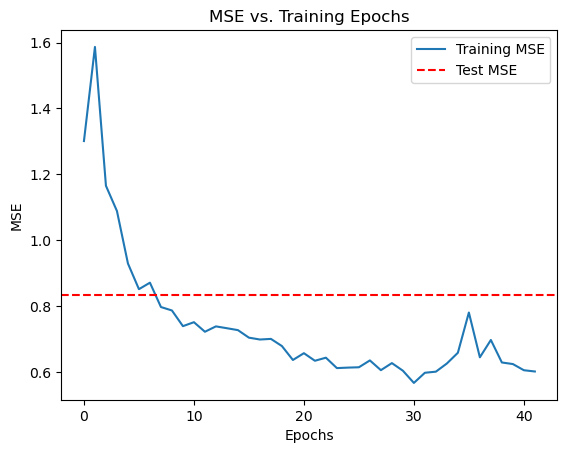

In [526]:
nn_model_loss = nn_model.fit(x_train_scaled, y_train_cs).loss_curve_
mse_test = mean_squared_error(y_test_cs, y_pred_nn)

# Plot the MSE over training epochs
plt.plot(nn_model_loss, label='Training MSE')
plt.axhline(y=mse_test, color='r', linestyle='--', label='Test MSE') # Reference point
plt.title('MSE vs. Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Regression Model for Team Performance